# Encontro 13: Medidas de Centralidade

Importando a biblioteca:

In [1]:
import sys
sys.path.append('..')

from random import choice
import pandas as pd
import scipy
import numpy as np
from itertools import permutations
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import socnet as sn

Configurando a biblioteca:

In [2]:
sn.node_size = 10
sn.node_color = (255, 255, 255)

sn.edge_width = 1
sn.edge_color = (192, 192, 192)

sn.node_label_position = 'top center'

Carregando rede de casamentos entre famílias de Florença durante a Renascença.

J. F. Padgett e C. K. Ansell. *Robust action and the rise of the Medici, 1400–1434.* American Journal of
Sociology 98, págs. 1259-1319, 1993.

In [3]:
g = sn.load_graph('Renaissance.gml', has_pos=True)

sn.show_graph(g, nlab=True)

Função que registra, em cada nó, seus sucessores em geodésicas de $s$ a $t$.

ps: Geodésica é o menor caminho possível que liga dois nós em um grafo.

In [4]:
def set_geodesic_successors(g, s, t):
    for n in g.nodes:
        g.nodes[n]['geodesic_successors'] = set()

    for p in nx.all_shortest_paths(g, s, t):
        for i in range(len(p) - 1):
            g.nodes[p[i]]['geodesic_successors'].add(p[i + 1])

Funções que representam uma escolha aleatória de sucessor para diferentes tipos de trajetórias.

In [5]:
# Pense que o atributo 'passages' abaixo indica quantas
# vezes um fluxo já passou por um nó ou por uma aresta.

def random_geodesic_successor(g, n):
    return choice([m for m in g.nodes[n]['geodesic_successors']])

def random_path_successor(g, n):
    return choice([m for m in g.neighbors(n) if g.nodes[m]['passages'] == 0])

def random_trail_successor(g, n):
    return choice([m for m in g.neighbors(n) if g.edges[n, m]['passages'] == 0])

def random_walk_successor(g, n):
    return choice([m for m in g.neighbors(n)])

Função que faz uma simulação de fluxo de $s$ a $t$, que pode ou não ser bem-sucedida.

In [6]:
def simulate_single_flow(g, s, t, sucessor_type, diffusion_type):
    # Inicializa o atributo 'passages' de cada nó.
    for n in g.nodes:
        g.nodes[n]['passages'] = 0
    g.nodes[s]['passages'] = 1

    # Inicializa o atributo 'passages' de cada aresta.
    for n, m in g.edges:
        g.edges[n, m]['passages'] = 0

    # Inicializa s como o único dono do insumo.
    for n in g.nodes:
        g.nodes[n]['owner'] = False
    g.nodes[s]['owner'] = True

    # Simula o fluxo, contando o número total de passos.

    steps = 0

    while True:
        # O conjunto reached representa todos os nós
        # que o fluxo consegue alcançar no passo atual.
        reached = set()

        # Verifica cada um dos donos atuais do insumo.

        owners = [n for n in g.nodes if g.nodes[n]['owner']]

        for n in owners:
            # Escolhe aleatoriamente um dos sucessores.
            try:
                if sucessor_type == "geodesic":
                    m = random_geodesic_successor(g, n)
                    
                if sucessor_type == "path":
                    m = random_path_successor(g, n)
                    
                if sucessor_type == "trail":
                    m = random_trail_successor(g, n)
                    
                if sucessor_type == "walk":
                    m = random_walk_successor(g, n)
                    
            except IndexError:
                continue

            if diffusion_type == "duplication":
                # Continua a ser dono do insumo.
                g.nodes[n]['owner'] = True
            if diffusion_type == "transfer":
                # Deixa de ser dono do insumo.
                g.nodes[n]['owner'] = False
                
            # Incrementa o atributo 'passages' do nó.
            g.nodes[m]['passages'] += 1

            # Incrementa o atributo 'passages' da aresta.
            g.edges[n, m]['passages'] += 1

            # Registra que consegue alcançar esse nó.
            reached.add(m)

        # Todo nó alcançado passa a ser dono do insumo.

        for n in reached:
            g.nodes[n]['owner'] = True

        # Isso conclui o passo atual da simulação.
        steps += 1

        # Se o passo alcançou t, chegamos ao fim da simulação.
        # Ela foi bem-sucedida: devolvemos o número de passos.
        if t in reached:
            return steps

        # Se o passo não alcançou ninguém, chegamos ao fim da
        # simulação. Ela não foi bem-sucedida: devolvemos -1.
        if not reached:
            return -1

Função que faz simulações de fluxo de $s$ a $t$ até uma ser bem-sucedida.

In [7]:
def simulate_successful_flow(g, s, t, sucessor_type, diffusion_type):
    set_geodesic_successors(g, s, t)

    while True:
        steps = simulate_single_flow(g, s, t, sucessor_type, diffusion_type)

        if steps != -1:
            return steps

Função que faz simulações de fluxo para todo $s$ e $t$ possíveis, e tira disso um *closeness simulado* e um *betweenness simulado*.

In [8]:
def simulate_all_flows(g, sucessor_type, diffusion_type):
    for n in g.nodes:
        g.nodes[n]['closeness'] = 0
        g.nodes[n]['betweenness'] = 0

    for s, t in permutations(g.nodes, 2):
        steps = simulate_successful_flow(g, s, t, sucessor_type, diffusion_type)

        g.nodes[s]['closeness'] += steps
        for n in g.nodes:
            if n != s and n != t:
                g.nodes[n]['betweenness'] += g.nodes[n]['passages']

    # Normalizações necessárias para comparar com os
    # resultados analíticos. Não é preciso entender.
    for n in g.nodes:
        g.nodes[n]['closeness'] = (g.number_of_nodes() - 1) / g.nodes[n]['closeness']
        g.nodes[n]['betweenness'] /= (g.number_of_nodes() - 1) * (g.number_of_nodes() - 2)

Média de *closeness simulado* e *betweenness simulado* para muitas repetições da simulação acima.

In [9]:
TIMES = 100

sucessor_type = ["geodesic", "path", "trail", "walk"]
diffusion_type = ["transfer", "duplication"]

for n in g.nodes:
    g.nodes[n]['mean_closeness'] = 0
    g.nodes[n]['mean_betweenness'] = 0

for _ in range(TIMES):
    simulate_all_flows(g, sucessor_type[0], diffusion_type[1])

    for n in g.nodes:
        g.nodes[n]['mean_closeness'] += g.nodes[n]['closeness']
        g.nodes[n]['mean_betweenness'] += g.nodes[n]['betweenness']

for n in g.nodes:
    g.nodes[n]['mean_closeness'] /= TIMES
    g.nodes[n]['mean_betweenness'] /= TIMES

Cálculo de *closeness* e *betweenness* a partir das funções prontas da NetworkX, para comparação.

In [10]:
cc = nx.closeness_centrality(g)
bc = nx.betweenness_centrality(g)

Construção de data frame só para comparar mais facilmente.

In [11]:
pd.DataFrame({
    'família': [g.nodes[n]['label'] for n in g.nodes],
    'closeness simulado': [g.nodes[n]['mean_closeness'] for n in g.nodes],
    'closeness analítico': [cc[n] for n in g.nodes],
    'betweenness simulado': [g.nodes[n]['mean_betweenness'] for n in g.nodes],
    'betweenness analítico': [bc[n] for n in g.nodes],
})

,família,closeness simulado,closeness analítico,betweenness simulado,betweenness analítico
0,ginori,0.333333,0.333333,0.000000,0.000000
1,lambertes,0.325581,0.325581,0.000000,0.000000
2,albizzi,0.482759,0.482759,0.569066,0.212454
3,guadagni,0.466667,0.466667,0.685714,0.260073
4,pazzi,0.285714,0.285714,0.000000,0.000000
5,salviati,0.388889,0.388889,0.406593,0.142857
6,medici,0.560000,0.560000,1.389780,0.521978
7,tornabuon,0.482759,0.482759,0.246593,0.091575
8,bischeri,0.400000,0.400000,0.314890,0.120879
9,ridolfi,0.482759,0.482759,0.249890,0.086081


E agora, vamos pensar um pouco...

* Onde você precisa mudar o código para usar uma *trajetória* que não seja a *geodésica*? (caminho, trilha, passeio)

* Onde você precisa mudar o código para usar uma *difusão* que não seja a *transferência*? (duplicação)

Considere então a seguinte **hipótese**:

>Quando consideramos outros tipos de trajetória e outros tipos de difusão, os nós com maior *closeness simulado* e *betweenness simulado* não são necessariamente os nós com maior *closeness* e *betweenness* segundo as fórmulas clássicas. (que correspondem ao uso de geodésica e transferência na simulação)

Queremos:

1. Operacionalização e teste dessas hipótese. (Objetivo 3)
2. Interpretação dos resultados na linguagem de Análise de Redes Sociais (Objetivo 4)

In [12]:
TIMES = 100

sucessor_type = ["geodesic", "path", "trail", "walk"]
diffusion_type = ["transfer", "duplication"]
families = ["ginori", "lambertes", "albizzi", "guadagni", "pazzi", "salviati", "medici", "tornabuon", "bischeri", "ridolfi", "acciaiuol", "strozzi", "peruzzi", "barbadori", "castellan"]
data_list = []

def createList():
    list = []
    for i in diffusion_type:
        list.append([])
        
        for j in sucessor_type:
            list[diffusion_type.index(i)].append([])
            
            for k in families:
                list[diffusion_type.index(i)][sucessor_type.index(j)].append([])
    return list

amostras_closeness = createList()
amostras_betweenness = createList()

w = sn.load_graph('Renaissance.gml', has_pos=True)

for t in diffusion_type:
    for i in sucessor_type:
        g = w.copy()
        for n in g.nodes:
            g.nodes[n]['mean_closeness'] = 0
            g.nodes[n]['mean_betweenness'] = 0

        for _ in range(TIMES):
            simulate_all_flows(g, sucessor_type[sucessor_type.index(i)], diffusion_type[diffusion_type.index(t)])
            
            c = 0
            for n in g.nodes:
                g.nodes[n]['mean_closeness'] += g.nodes[n]['closeness']
                amostras_closeness[diffusion_type.index(t)][sucessor_type.index(i)][c].append(g.nodes[n]['closeness'])
                
                g.nodes[n]['mean_betweenness'] += g.nodes[n]['betweenness']
                amostras_betweenness[diffusion_type.index(t)][sucessor_type.index(i)][c].append(g.nodes[n]['betweenness'])
                c += 1
                
        for n in g.nodes:
            g.nodes[n]['mean_closeness'] /= TIMES
            g.nodes[n]['mean_betweenness'] /= TIMES

        cc = nx.closeness_centrality(g)

        bc = nx.betweenness_centrality(g)
        data = pd.DataFrame({
            'família': [g.nodes[n]['label'] for n in g.nodes],
            'closeness simulado': [g.nodes[n]['mean_closeness'] for n in g.nodes],
            'closeness analítico': [cc[n] for n in g.nodes],
            'betweenness simulado': [g.nodes[n]['mean_betweenness'] for n in g.nodes],
            'betweenness analítico': [bc[n] for n in g.nodes],
            'sucessor type': i,
            'diffusion_type': t,
            'closeness_100_pvalue': [scipy.stats.ttest_ind(amostras_closeness[diffusion_type.index(t)][sucessor_type.index(i)][n], amostras_closeness[0][0][n], equal_var=False)[1] for n in g.nodes],
            'betweenness_100_pvalue': [scipy.stats.ttest_ind(amostras_betweenness[diffusion_type.index(t)][sucessor_type.index(i)][n], amostras_betweenness[0][0][n], equal_var=False)[1] for n in g.nodes]
        })

        data.name = i
        data_list.append(data)                                   

In [13]:
result = pd.concat(data_list, ignore_index=True)

In [14]:
def color_diffusion(diffusion):
    if diffusion == "geodesic":
        color = '#1F77B4'
    elif diffusion == "trail":
        color = '#2CA02C'
    elif diffusion == "path":
        color = '#FF7F0E'
    elif diffusion == "walk":
        color = '#D62728'
    else:
        color = 'black'
    return 'color: %s' % color

def is_nan(x):
    return (x is np.nan or x != x)

def pvalue_color(pvalue):
    if pvalue == 1:
        color = '#3EFF00'
    elif is_nan(pvalue):
        color = 'yellow'
    else:
        color = ''
    return 'background-color: %s' % color

In [15]:
result.style.format({'closeness_100_pvalue': "{:.2e}", 'betweenness_100_pvalue': '{:.2e}'}).applymap(color_diffusion).applymap(pvalue_color)

,família,closeness simulado,closeness analítico,betweenness simulado,betweenness analítico,sucessor type,diffusion_type,closeness_100_pvalue,betweenness_100_pvalue
0,ginori,0.333333,0.333333,0,0,geodesic,transfer,1.00e+00,nan
1,lambertes,0.325581,0.325581,0,0,geodesic,transfer,1.00e+00,nan
2,albizzi,0.482759,0.482759,0.212582,0.212454,geodesic,transfer,1.00e+00,1.00e+00
3,guadagni,0.466667,0.466667,0.255879,0.260073,geodesic,transfer,1.00e+00,1.00e+00
4,pazzi,0.285714,0.285714,0,0,geodesic,transfer,1.00e+00,nan
5,salviati,0.388889,0.388889,0.142857,0.142857,geodesic,transfer,1.00e+00,1.00e+00
6,medici,0.56,0.56,0.522308,0.521978,geodesic,transfer,1.00e+00,1.00e+00
7,tornabuon,0.482759,0.482759,0.0875824,0.0915751,geodesic,transfer,1.00e+00,1.00e+00
8,bischeri,0.4,0.4,0.120879,0.120879,geodesic,transfer,1.00e+00,1.00e+00
9,ridolfi,0.482759,0.482759,0.0903846,0.0860806,geodesic,transfer,1.00e+00,1.00e+00


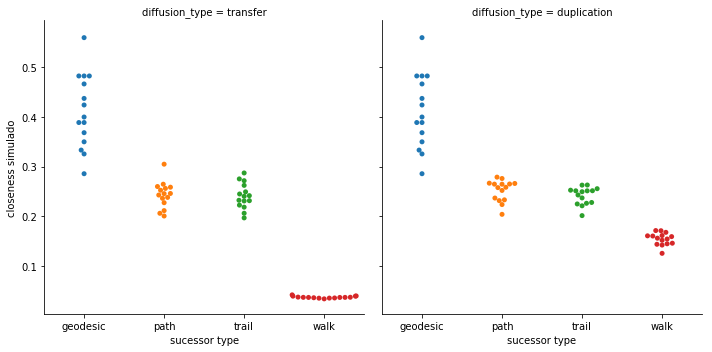

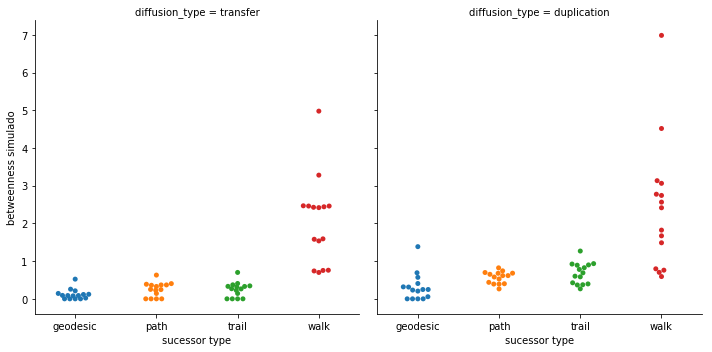

In [16]:
def plot_hist(rel1, rel2):
    sns.catplot(x=rel1, y=rel2, kind="swarm", col="diffusion_type", data=result)
    
plot_hist("sucessor type", "closeness simulado")
#plot_hist("sucessor type", "closeness analítico")
plot_hist("sucessor type", "betweenness simulado")
#plot_hist("sucessor type", "betweenness analítico")

In [17]:
transfer = pd.concat(data_list[:4], ignore_index=True)

In [18]:
duplication = pd.concat(data_list[4:], ignore_index=True)

In [19]:
close_transfer = transfer[["família", "closeness simulado", "sucessor type", 'closeness_100_pvalue']].sort_values(by=['closeness simulado'], ascending=False).style.format({'closeness_100_pvalue': "{:.2e}"}).applymap(color_diffusion).applymap(pvalue_color)

In [20]:
close_dupli = duplication[["família", "closeness simulado", "sucessor type", 'closeness_100_pvalue']].sort_values(by=['closeness simulado'], ascending=False).style.format({'closeness_100_pvalue': "{:.2e}"}).applymap(color_diffusion).applymap(pvalue_color)

In [21]:
betw_transfer = transfer[["família", "betweenness simulado", "sucessor type", 'betweenness_100_pvalue']].sort_values(by=['betweenness simulado'], ascending=False).style.format({'betweenness_100_pvalue': '{:.2e}'}).applymap(color_diffusion).applymap(pvalue_color)

In [22]:
betw_dupli = duplication[["família", "betweenness simulado", "sucessor type", 'betweenness_100_pvalue']].sort_values(by=['betweenness simulado'], ascending=False).style.format({'betweenness_100_pvalue': '{:.2e}'}).applymap(color_diffusion).applymap(pvalue_color)

In [23]:
result[["família", "betweenness simulado", "sucessor type", "diffusion_type", 'betweenness_100_pvalue']].sort_values(by=['betweenness simulado', 'diffusion_type'], ascending=False).style.format({'betweenness_100_pvalue': '{:.2e}'}).applymap(color_diffusion).applymap(pvalue_color)

,família,betweenness simulado,sucessor type,diffusion_type,betweenness_100_pvalue
111,medici,6.98577,walk,duplication,1.40e-103
51,medici,4.97725,walk,transfer,3.87e-102
108,guadagni,4.5167,walk,duplication,8.90e-98
48,guadagni,3.28,walk,transfer,3.34e-90
119,castellan,3.13308,walk,duplication,2.28e-104
107,albizzi,3.06297,walk,duplication,7.98e-96
113,bischeri,2.77412,walk,duplication,1.05e-101
116,strozzi,2.74198,walk,duplication,6.08e-102
114,ridolfi,2.56467,walk,duplication,1.08e-104
52,tornabuon,2.46703,walk,transfer,5.35e-99


In [24]:
result[["família", "closeness simulado", "sucessor type", "diffusion_type", 'closeness_100_pvalue']].sort_values(by=['closeness simulado', "diffusion_type"], ascending=False).style.format({'closeness_100_pvalue': '{:.2e}'}).applymap(color_diffusion).applymap(pvalue_color)

,família,closeness simulado,sucessor type,diffusion_type,closeness_100_pvalue
6,medici,0.56,geodesic,transfer,1.00e+00
66,medici,0.56,geodesic,duplication,1.00e+00
2,albizzi,0.482759,geodesic,transfer,1.00e+00
7,tornabuon,0.482759,geodesic,transfer,1.00e+00
9,ridolfi,0.482759,geodesic,transfer,1.00e+00
62,albizzi,0.482759,geodesic,duplication,1.00e+00
67,tornabuon,0.482759,geodesic,duplication,1.00e+00
69,ridolfi,0.482759,geodesic,duplication,1.00e+00
3,guadagni,0.466667,geodesic,transfer,1.00e+00
63,guadagni,0.466667,geodesic,duplication,1.00e+00


In [25]:
for i in data_list:
    describe_obj = i["betweenness simulado"].describe()
    print(i.name, i["diffusion_type"][0], "\n", "Media: ", describe_obj['mean'], "\n Desvio padrão: ", describe_obj['std'], "\n")

geodesic transfer 
 Media:  0.11575091575091566 
 Desvio padrão:  0.1365688598215311 

path transfer 
 Media:  0.24747619047619043 
 Desvio padrão:  0.1880049545451081 

trail transfer 
 Media:  0.2464798534798534 
 Desvio padrão:  0.19456109843300093 

walk transfer 
 Media:  2.0391868131868134 
 Desvio padrão:  1.152977372374939 

geodesic duplication 
 Media:  0.3113113553113553 
 Desvio padrão:  0.3633786046642195 

path duplication 
 Media:  0.5660219780219781 
 Desvio padrão:  0.1580368445833567 

trail duplication 
 Media:  0.6813003663003663 
 Desvio padrão:  0.2824552348828218 

walk duplication 
 Media:  2.401424908424908 
 Desvio padrão:  1.6880140328312498 



In [26]:
for i in data_list:
    describe_obj = i["closeness simulado"].describe()
    print(i.name, i["diffusion_type"][0], "\n", "Media: ", describe_obj['mean'], "\n Desvio padrão: ", describe_obj['std'], "\n")

geodesic transfer 
 Media:  0.4118341865189247 
 Desvio padrão:  0.0742931351683979 

path transfer 
 Media:  0.2433109159202679 
 Desvio padrão:  0.026197924743218463 

trail transfer 
 Media:  0.24064935075123117 
 Desvio padrão:  0.025502606955047663 

walk transfer 
 Media:  0.03680690220595954 
 Desvio padrão:  0.0020738101956912355 

geodesic duplication 
 Media:  0.4118341865189247 
 Desvio padrão:  0.0742931351683979 

path duplication 
 Media:  0.2518965791289999 
 Desvio padrão:  0.02140780216481674 

trail duplication 
 Media:  0.2411756638437596 
 Desvio padrão:  0.017618489541234555 

walk duplication 
 Media:  0.1541508952944451 
 Desvio padrão:  0.012449191834348608 



In [27]:
list_familias = result['família'][:15].values

#Tranfer
list_geodesic_ct = result['closeness simulado'][:15].values
list_geodesic_bt = result['betweenness simulado'][:15].values

list_path_ct = result['closeness simulado'][15:30].values
list_path_bt = result['betweenness simulado'][15:30].values


list_trail_ct = result['closeness simulado'][30:45].values
list_trail_bt = result['betweenness simulado'][30:45].values


list_walk_ct = result['closeness simulado'][45:60].values
list_walk_bt = result['betweenness simulado'][45:60].values



#Duplication
list_geodesic_cd = result['closeness simulado'][60:75].values
list_geodesic_bd = result['betweenness simulado'][60:75].values


list_path_cd  = result['closeness simulado'][75:90].values
list_path_bd = result['betweenness simulado'][75:90].values


list_trail_cd  = result['closeness simulado'][90:105].values
list_trail_bd = result['betweenness simulado'][90:105].values


list_walk_cd  = result['closeness simulado'][105:120].values
list_walk_bd = result['betweenness simulado'][105:120].values

a = zip( list_familias,list_geodesic_ct,list_path_ct,list_trail_ct,list_walk_ct)

data_close = pd.DataFrame({
    'Família': list_familias,
    'Geodesic Transfer': list_geodesic_ct,
    'Path Transfer': list_path_ct,
    'Trail Transfer': list_trail_ct,
    'Walk Transfer': list_walk_ct,
    'Geodesic Duplication': list_geodesic_cd,
    'Path Duplication': list_path_cd,
    'Trail Duplication': list_trail_cd,
    'Walk Duplication': list_walk_cd,
})


data_betw = pd.DataFrame({
    'Família': list_familias,
    'Geodesic Transfer': list_geodesic_bt,
    'Path Transfer': list_path_bt,
    'Trail Transfer': list_trail_bt,
    'Walk Transfer': list_walk_bt,
    'Geodesic Duplication': list_geodesic_bd,
    'Path Duplication': list_path_bd,
    'Trail Duplication': list_trail_bd,
    'Walk Duplication': list_walk_bd,
})

In [28]:
s1 = data_close.style.background_gradient(cmap='Wistia', axis=1)
s1

,Família,Geodesic Transfer,Path Transfer,Trail Transfer,Walk Transfer,Geodesic Duplication,Path Duplication,Trail Duplication,Walk Duplication
0,ginori,0.333333,0.205937,0.218299,0.0369864,0.333333,0.231443,0.224742,0.14189
1,lambertes,0.325581,0.211315,0.206016,0.0366818,0.325581,0.233049,0.22774,0.143456
2,albizzi,0.482759,0.259897,0.275229,0.0388963,0.482759,0.257691,0.251269,0.161126
3,guadagni,0.466667,0.264567,0.271638,0.0334584,0.466667,0.266628,0.252498,0.158951
4,pazzi,0.285714,0.200465,0.19665,0.0415167,0.285714,0.203842,0.201266,0.125218
5,salviati,0.388889,0.245887,0.240206,0.0389257,0.388889,0.223544,0.221044,0.14446
6,medici,0.56,0.30495,0.287229,0.035697,0.56,0.264576,0.251414,0.167533
7,tornabuon,0.482759,0.256055,0.249176,0.0352615,0.482759,0.278837,0.26296,0.171136
8,bischeri,0.4,0.245529,0.230796,0.0363142,0.4,0.264955,0.249412,0.154122
9,ridolfi,0.482759,0.258558,0.244855,0.0364173,0.482759,0.276062,0.262712,0.170803


In [29]:
s2 = data_betw.style.background_gradient(cmap='Wistia', axis=1)
s2

,Família,Geodesic Transfer,Path Transfer,Trail Transfer,Walk Transfer,Geodesic Duplication,Path Duplication,Trail Duplication,Walk Duplication
0,ginori,0,0,0,0.739011,0,0.391209,0.373681,0.795879
1,lambertes,0,0,0,0.752747,0,0.400714,0.395714,0.701538
2,albizzi,0.212582,0.228626,0.268077,2.46044,0.570055,0.61544,0.689451,3.06297
3,guadagni,0.255879,0.403516,0.407143,3.28,0.691099,0.741923,0.899231,4.5167
4,pazzi,0,0,0,0.699615,0,0.262802,0.26522,0.760055
5,salviati,0.142857,0.142857,0.142857,1.53593,0.406593,0.437473,0.425385,1.82236
6,medici,0.522308,0.62989,0.700055,4.97725,1.38368,0.821758,1.26731,6.98577
7,tornabuon,0.0875824,0.328516,0.31478,2.46703,0.246923,0.68033,0.933626,2.4144
8,bischeri,0.120879,0.368516,0.343242,2.44093,0.312253,0.650604,0.779505,2.77412
9,ridolfi,0.0903846,0.359725,0.330989,2.46049,0.247473,0.697912,0.922308,2.56467
